In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from geopy.distance import geodesic
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from gensim.models import Word2Vec
import os
import dash
from dash import dcc, html, Input, Output, callback_context
from itertools import combinations
import re

In [2]:
# 定義輸出資料夾路徑
OUTPUT_DIR = 'C:/Users/user/Desktop/ML_Work4/outputs'
DATA_DIR = 'C:/Users/user/Desktop/ML_Work4/data'

# 創建輸出資料夾
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# 創建資料資料夾
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)


In [3]:
def process_train_stations():
    """處理火車站資料集，使用MDS進行視覺化"""
    stations = {
        '台北': (25.0477, 121.5174),
        '新竹': (24.8021, 120.9715),
        '台中': (24.1376, 120.6870),
        '斗六': (23.7121, 120.5410),
        '玉里': (23.3321, 121.3117),
        '知本': (22.7103, 121.0606),
        '高雄': (22.6398, 120.3028),
    }
    
    # 計算距離矩陣
    station_names = list(stations.keys())
    n = len(stations)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i, j] = geodesic(stations[station_names[i]], stations[station_names[j]]).km
    
    # 應用 MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(dist_matrix)
    
    # 保存結果
    fig = px.scatter(x=mds_coords[:, 0], y=mds_coords[:, 1], text=station_names, 
                     title='MDS：台灣火車站相對位置')
    fig.update_traces(textposition='top center', marker=dict(size=10))
    fig.update_layout(xaxis_title='MDS 維度 1', yaxis_title='MDS 維度 2')
    fig.write_image(file=os.path.join(OUTPUT_DIR, 'mds_train_stations.png'), format='png')
    
    # 建立地圖
    create_google_map(stations)
    
    return mds_coords, station_names

In [4]:
def create_google_map(stations):
    """創建包含火車站標記的地圖"""
    center_lat = sum([coord[0] for coord in stations.values()]) / len(stations)
    center_lon = sum([coord[1] for coord in stations.values()]) / len(stations)
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=7)
    
    for name, (lat, lon) in stations.items():
        folium.Marker(
            location=[lat, lon],
            popup=f'{name}火車站',
            tooltip=name,
            icon=folium.Icon(color='red', icon='train', prefix='fa')
        ).add_to(m)
    
    m.save(os.path.join(OUTPUT_DIR, 'train_stations_map.html'))
    return m

In [5]:
def load_drink_dataset():
    """讀取飲料資料集"""
    file_path = r'C:\Users\user\Desktop\ML_Work4\data\drinkset.xlsx'
    
    try:
        df = pd.read_excel(file_path)
        print("飲料資料集載入成功！")
        print(f"資料形狀：{df.shape}")
        print("欄位名稱：", df.columns.tolist())
        
        # 標準化欄位名稱
        column_mapping = {}
        for col in df.columns:
            col_lower = col.lower()
            if col_lower in ['class', '類別']:
                column_mapping[col] = 'Class'
            elif col_lower in ['drink', '飲料']:
                column_mapping[col] = 'Drink'
            elif col_lower in ['rank', '排名']:
                column_mapping[col] = 'Rank'
            elif col_lower in ['amount', '金額']:
                column_mapping[col] = 'Amount'
            elif col_lower in ['quantity', '數量']:
                column_mapping[col] = 'Quantity'
            elif col_lower in ['count', '計數']:
                column_mapping[col] = 'Count'
        
        df = df.rename(columns=column_mapping)
        return df
        
    except FileNotFoundError:
        print(f"錯誤：找不到檔案 {file_path}")
        return None
    except Exception as e:
        print(f"讀取檔案時發生錯誤：{e}")
        return None

In [6]:
def expand_drink_data(df):
    """展開飲料資料（處理Count欄位）"""
    if 'Count' not in df.columns:
        return df.copy()
    
    print("展開資料...")
    expanded_data = []
    np.random.seed(42)
    
    for _, row in df.iterrows():
        count = int(row['Count'])
        for _ in range(count):
            # 處理Amount欄位
            amount_str = str(row['Amount'])
            if '(' in amount_str and ')' in amount_str:
                amount_clean = amount_str.strip('()').replace(' ', '')
                try:
                    mean, std = map(float, amount_clean.split(','))
                    amount_value = np.random.normal(mean, std)
                except:
                    amount_value = 100
            else:
                try:
                    amount_value = float(amount_str)
                except:
                    amount_value = 100
            
            # 處理Quantity欄位
            quantity_str = str(row['Quantity'])
            if 'Random' in quantity_str or 'random' in quantity_str:
                numbers = re.findall(r'\d+', quantity_str)
                if len(numbers) >= 2:
                    min_qty, max_qty = int(numbers[0]), int(numbers[1])
                    qty_value = np.random.randint(min_qty, max_qty + 1)
                else:
                    qty_value = 500
            else:
                try:
                    qty_value = float(quantity_str)
                except:
                    qty_value = 500
            
            expanded_data.append([
                row['Class'], row['Drink'], row['Rank'], amount_value, qty_value
            ])
    
    expanded_df = pd.DataFrame(expanded_data, 
                             columns=['Class', 'Drink', 'Rank', 'Amount', 'Quantity'])
    print(f"資料展開完成：從 {len(df)} 行展開為 {len(expanded_df)} 行")
    return expanded_df

In [7]:
def compute_manual_dissimilarity_matrix(drinks, same_category_diss, cross_category_diss):
    """計算手動設定的不相似度矩陣"""
    drink_groups = [
        ['Coke', 'Pepsi', 'Sprite', '7Up'],
        ['Cappuccino', 'Espresso', 'Latte', 'Mocha'],
    ]
    
    # 建立不相似度字典
    dissimilarity = {}
    for group in drink_groups:
        for pair in combinations(group, 2):
            sorted_pair = tuple(sorted(pair))
            dissimilarity[sorted_pair] = same_category_diss
    
    # 建立距離矩陣
    n = len(drinks)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                pair = tuple(sorted([drinks[i], drinks[j]]))
                dist_matrix[i, j] = dissimilarity.get(pair, cross_category_diss)
    
    return dist_matrix

In [1]:
def compute_word2vec_dissimilarity_matrix(df):
    """計算Word2Vec不相似度矩陣"""
    unique_drinks = df['Drink'].unique()
    
    # 準備訓練資料
    sentences = []
    for drink in unique_drinks:
        if any(beverage in drink.lower() for beverage in ['coke', 'pepsi', 'sprite', '7up']):
            sentence = ['Carbonated', 'bubble', 'Cool', drink]
        else:
            sentence = ['coffee', 'Hot', 'caffeine', drink]
        sentences.append(sentence)
    
    # 訓練Word2Vec模型
    model = Word2Vec(sentences, vector_size=1, window=1, min_count=1, workers=1, seed=42)
    
    # 計算不相似度矩陣
    n = len(unique_drinks)
    dist_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                try:
                    similarity = model.wv.similarity(unique_drinks[i], unique_drinks[j])
                    dist_matrix[i, j] = 1 - similarity
                except KeyError:
                    dist_matrix[i, j] = 1.0
    
    return dist_matrix, unique_drinks


In [9]:
def tsne_one_hot(df):
    """使用One-hot編碼的t-SNE分析"""
    expanded_df = expand_drink_data(df)
    
    # One-hot編碼
    encoder = OneHotEncoder(sparse_output=False)
    drink_encoded = encoder.fit_transform(expanded_df[['Drink']])
    
    # 數值特徵
    numerical_features = expanded_df[['Rank', 'Amount', 'Quantity']].astype(float)
    features = np.hstack([drink_encoded, numerical_features.values])
    
    # 標準化
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # t-SNE
    n_samples = len(expanded_df)
    perplexity = min(50, max(5, n_samples // 4))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
    tsne_coords = tsne.fit_transform(features_scaled)
    
    # 建立結果DataFrame，加入索引
    plot_df = pd.DataFrame({
        'X': tsne_coords[:, 0],
        'Y': tsne_coords[:, 1],
        'Class': expanded_df['Class'],
        'Drink': expanded_df['Drink'],
        'Rank': expanded_df['Rank'],
        'Amount': expanded_df['Amount'],
        'Quantity': expanded_df['Quantity'],
        'Index': range(len(expanded_df))
    })
    
    # 建立並保存圖表
    fig = px.scatter(plot_df, x='X', y='Y', color='Drink', 
                     title='t-SNE（One-hot編碼）',
                     hover_data=['Drink', 'Rank', 'Amount', 'Quantity'])
    fig.update_layout(xaxis_title='t-SNE 維度 1', yaxis_title='t-SNE 維度 2')
    
    # 保存結果
    print(f"   保存One-hot t-SNE圖片到: {os.path.join(OUTPUT_DIR, 'tsne_one_hot.png')}")
    fig.write_image(file=os.path.join(OUTPUT_DIR, 'tsne_one_hot.png'), format='png')
    plot_df.to_csv(os.path.join(OUTPUT_DIR, 'tsne_one_hot.csv'), index=False)
    print(f"   保存One-hot t-SNE資料到: {os.path.join(OUTPUT_DIR, 'tsne_one_hot.csv')}")
    
    return plot_df

In [10]:
def tsne_manual_combination(df, same_diss, cross_diss):
    """手動不相似度組合的t-SNE分析"""
    expanded_df = expand_drink_data(df)
    unique_drinks = expanded_df['Drink'].unique()
    drink_to_idx = {drink: idx for idx, drink in enumerate(unique_drinks)}
    
    # 數值特徵標準化
    numerical_features = StandardScaler().fit_transform(
        expanded_df[['Rank', 'Amount', 'Quantity']].astype(float)
    )
    
    # 計算不相似度矩陣
    dist_matrix = compute_manual_dissimilarity_matrix(unique_drinks, same_diss, cross_diss)
    
    # 結合不相似度與數值特徵
    n = len(expanded_df)
    combined_dist = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                numerical_dist = np.sqrt(np.sum((numerical_features[i] - numerical_features[j])**2))
                drink_i_idx = drink_to_idx[expanded_df.iloc[i]['Drink']]
                drink_j_idx = drink_to_idx[expanded_df.iloc[j]['Drink']]
                drink_dissim = dist_matrix[drink_i_idx, drink_j_idx]
                combined_dist[i, j] = drink_dissim + numerical_dist
    
    # t-SNE
    n_samples = len(expanded_df)
    perplexity = min(50, max(5, n_samples // 4))
    
    tsne = TSNE(n_components=2, metric='precomputed', init='random', 
                random_state=42, perplexity=perplexity)
    tsne_coords = tsne.fit_transform(combined_dist)
    
    # 建立結果DataFrame
    plot_df = pd.DataFrame({
        'X': tsne_coords[:, 0],
        'Y': tsne_coords[:, 1],
        'Class': expanded_df['Class'],
        'Drink': expanded_df['Drink'],
        'Rank': expanded_df['Rank'],
        'Amount': expanded_df['Amount'],
        'Quantity': expanded_df['Quantity'],
        'Index': range(len(expanded_df))
    })
    
    return plot_df


In [11]:
def tsne_word2vec(df):
    """使用Word2Vec不相似度的t-SNE分析"""
    expanded_df = expand_drink_data(df)
    
    # 計算Word2Vec不相似度
    dist_matrix, unique_drinks = compute_word2vec_dissimilarity_matrix(expanded_df)
    drink_to_idx = {drink: idx for idx, drink in enumerate(unique_drinks)}
    
    # 數值特徵標準化
    numerical_features = StandardScaler().fit_transform(
        expanded_df[['Rank', 'Amount', 'Quantity']].astype(float)
    )
    
    # 結合不相似度與數值特徵
    n = len(expanded_df)
    combined_dist = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                numerical_dist = np.sqrt(np.sum((numerical_features[i] - numerical_features[j])**2))
                drink_i_idx = drink_to_idx[expanded_df.iloc[i]['Drink']]
                drink_j_idx = drink_to_idx[expanded_df.iloc[j]['Drink']]
                drink_dissim = dist_matrix[drink_i_idx, drink_j_idx]
                combined_dist[i, j] = drink_dissim + numerical_dist
    
    # t-SNE
    n_samples = len(expanded_df)
    perplexity = min(50, max(5, n_samples // 4))
    
    tsne = TSNE(n_components=2, metric='precomputed', init='random', 
                random_state=42, perplexity=perplexity)
    tsne_coords = tsne.fit_transform(combined_dist)
    
    # 建立結果DataFrame
    plot_df = pd.DataFrame({
        'X': tsne_coords[:, 0],
        'Y': tsne_coords[:, 1],
        'Class': expanded_df['Class'],
        'Drink': expanded_df['Drink'],
        'Rank': expanded_df['Rank'],
        'Amount': expanded_df['Amount'],
        'Quantity': expanded_df['Quantity'],
        'Index': range(len(expanded_df))
    })
    
    # 建立並保存圖表
    fig = px.scatter(plot_df, x='X', y='Y', color='Drink', 
                     title='t-SNE（Word2Vec不相似度）',
                     hover_data=['Drink', 'Rank', 'Amount', 'Quantity'])
    fig.update_layout(xaxis_title='t-SNE 維度 1', yaxis_title='t-SNE 維度 2')
    
    # 保存結果
    print(f"   保存Word2Vec t-SNE圖片到: {os.path.join(OUTPUT_DIR, 'tsne_word2vec.png')}")
    fig.write_image(file=os.path.join(OUTPUT_DIR, 'tsne_word2vec.png'), format='png')
    plot_df.to_csv(os.path.join(OUTPUT_DIR, 'tsne_word2vec.csv'), index=False)
    print(f"   保存Word2Vec t-SNE資料到: {os.path.join(OUTPUT_DIR, 'tsne_word2vec.csv')}")
    
    return plot_df

In [12]:
def create_interactive_mds_plot(mds_coords, station_names):
    """建立火車站MDS互動圖表"""
    mds_df = pd.DataFrame({
        'X': mds_coords[:, 0],
        'Y': mds_coords[:, 1],
        'Station': station_names,
        'Type': '火車站',
        'Index': range(len(station_names))
    })
    
    fig = px.scatter(
        mds_df, x='X', y='Y', 
        text='Station',
        title='MDS：台灣火車站相對位置',
        hover_data=['Station']
    )
    
    fig.update_traces(
        textposition='top center', 
        marker=dict(size=12, color='darkorange'),
        textfont=dict(size=10)
    )
    
    fig.update_layout(
        xaxis_title='MDS 維度 1',
        yaxis_title='MDS 維度 2',
        dragmode='select',
        selectdirection='d',
        hovermode='closest',
        height=500
    )
    
    return fig, mds_df

In [13]:
def create_interactive_tsne_plot(data_df, title, method_type=""):
    """建立t-SNE互動圖表"""
    fig = px.scatter(
        data_df, x='X', y='Y', 
        color='Drink',
        title=title,
        hover_data=['Drink', 'Class', 'Rank', 'Amount', 'Quantity']
    )
    
    fig.update_layout(
        xaxis_title='t-SNE 維度 1',
        yaxis_title='t-SNE 維度 2',
        dragmode='select',
        selectdirection='d',
        hovermode='closest',
        height=500
    )
    
    return fig


In [14]:
def display_selection_info_single(selected_data, data_df, plot_title):
    """顯示單一圖表選中資料的詳細資訊"""
    if selected_data is None or 'points' not in selected_data:
        print(f"{plot_title}: 尚未選擇任何資料點")
        return
    
    selected_points = selected_data['points']
    if len(selected_points) == 0:
        print(f"{plot_title}: 尚未選擇任何資料點")
        return
    
    print(f"\n{plot_title} - 選中了 {len(selected_points)} 個資料點：")
    print("="*60)
    
    selected_indices = [point['pointIndex'] for point in selected_points]
    selected_df = data_df.iloc[selected_indices]
    
    # 顯示選中資料的摘要
    if 'Station' in data_df.columns:
        # 火車站資料
        stations = selected_df['Station'].tolist()
        print(f"選中火車站: {', '.join(stations)}")
    else:
        # 飲料資料
        drink_counts = selected_df['Drink'].value_counts()
        print(f"飲料類型分布:")
        for drink, count in drink_counts.items():
            print(f"   {drink}: {count} 點")
        
        print(f"\n統計資訊:")
        if 'Rank' in selected_df.columns:
            print(f"   排名範圍: {selected_df['Rank'].min():.1f} - {selected_df['Rank'].max():.1f}")
        if 'Amount' in selected_df.columns:
            print(f"   金額範圍: {selected_df['Amount'].min():.1f} - {selected_df['Amount'].max():.1f}")
        if 'Quantity' in selected_df.columns:
            print(f"   數量範圍: {selected_df['Quantity'].min():.1f} - {selected_df['Quantity'].max():.1f}")
    
    print("="*60)

開始執行機器學習作業四...
讀取飲料資料集...
飲料資料集載入成功！
資料形狀：(8, 6)
欄位名稱： ['Class', 'Drink', 'Rank', 'Amount', 'Quantity', 'Count']
飲料資料集載入完成

開始生成所有互動式圖表

1. 火車站MDS圖...


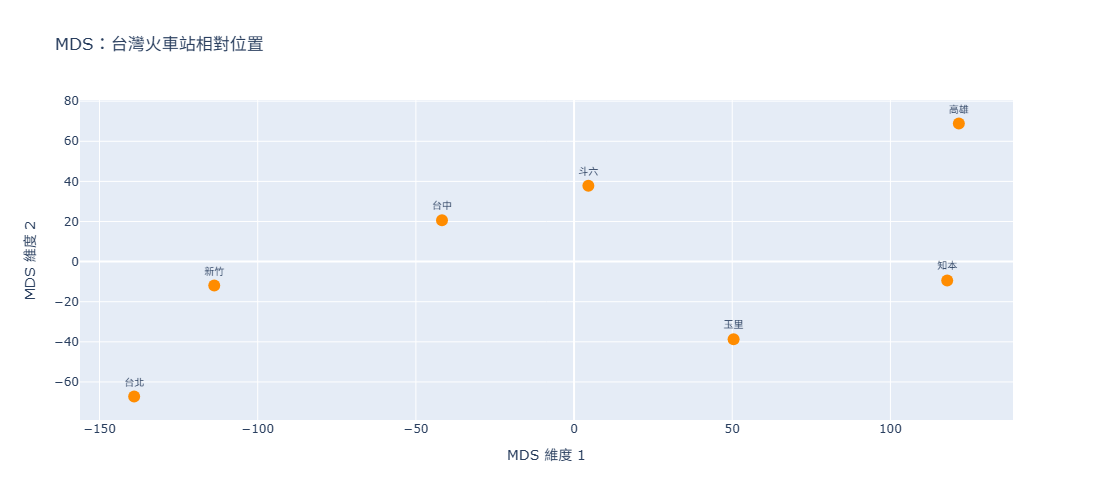

火車站MDS圖顯示完成

 2. t-SNE (One-hot編碼)...
展開資料...
資料展開完成：從 8 行展開為 1600 行
   保存One-hot t-SNE圖片到: C:/Users/user/Desktop/ML_Work4/outputs\tsne_one_hot.png
   保存One-hot t-SNE資料到: C:/Users/user/Desktop/ML_Work4/outputs\tsne_one_hot.csv


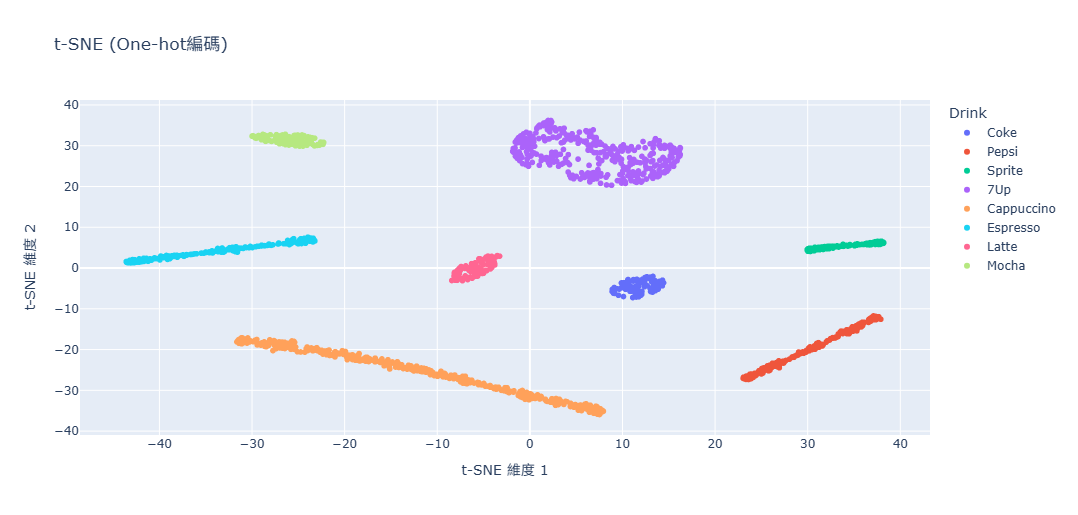

One-hot編碼t-SNE顯示完成

⚙️  3. 九種手動不相似度組合t-SNE...
   📊 組合 1/9: 同類別=0, 跨類別=4
展開資料...
資料展開完成：從 8 行展開為 1600 行


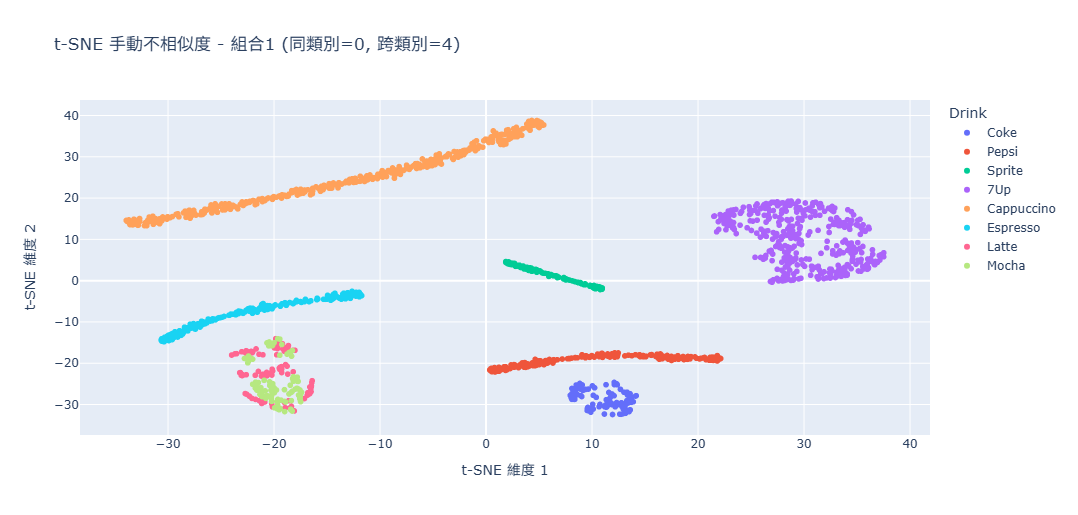

   📊 組合 2/9: 同類別=0, 跨類別=6
展開資料...
資料展開完成：從 8 行展開為 1600 行


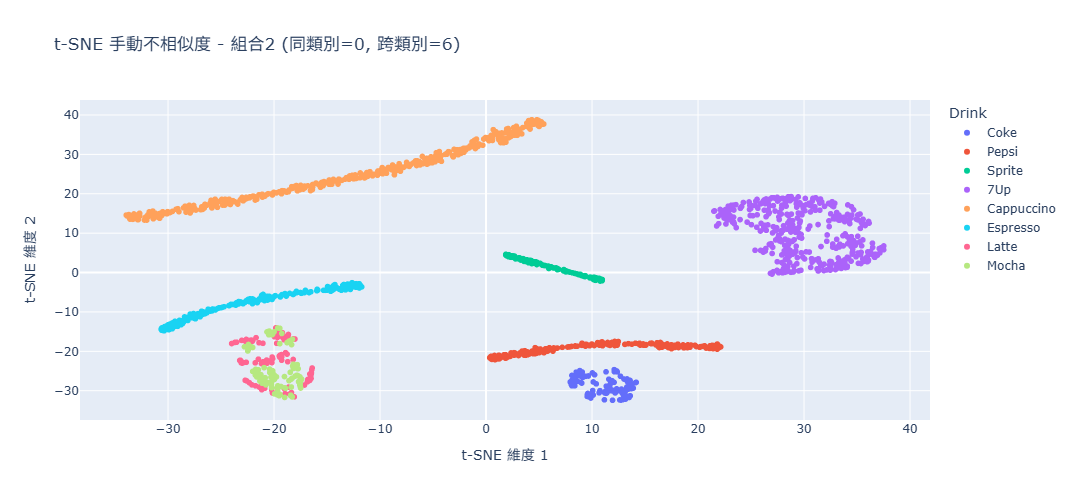

   📊 組合 3/9: 同類別=0, 跨類別=8
展開資料...
資料展開完成：從 8 行展開為 1600 行


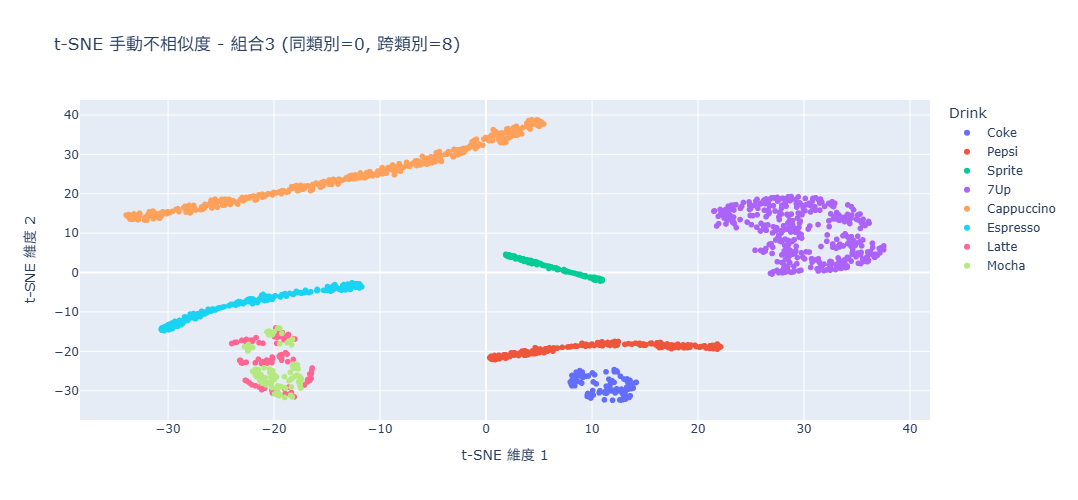

   📊 組合 4/9: 同類別=1, 跨類別=4
展開資料...
資料展開完成：從 8 行展開為 1600 行


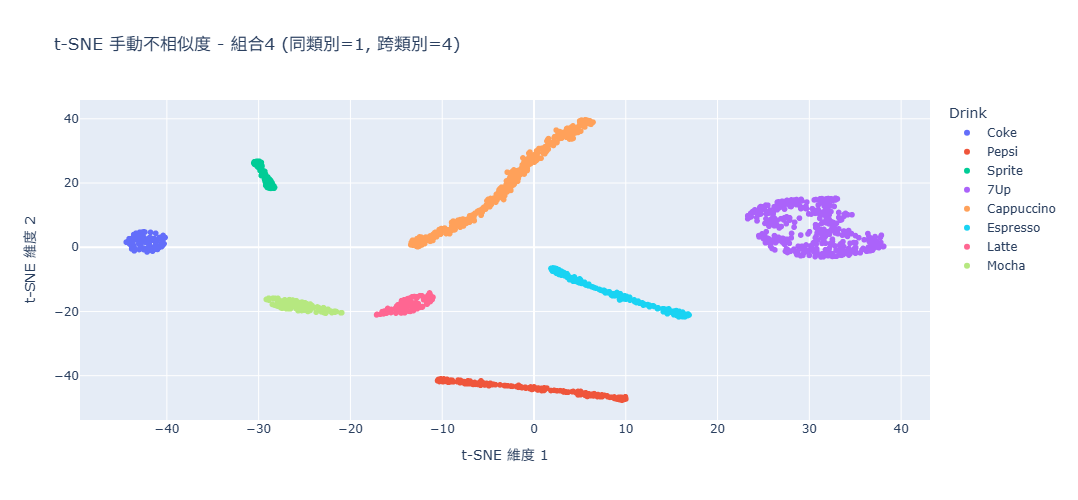

   📊 組合 5/9: 同類別=1, 跨類別=6
展開資料...
資料展開完成：從 8 行展開為 1600 行


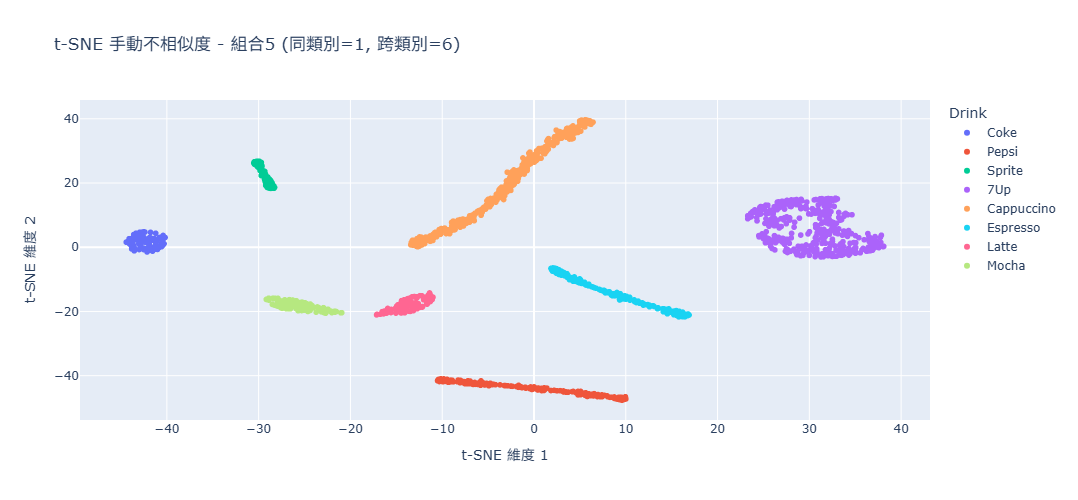

   📊 組合 6/9: 同類別=1, 跨類別=8
展開資料...
資料展開完成：從 8 行展開為 1600 行


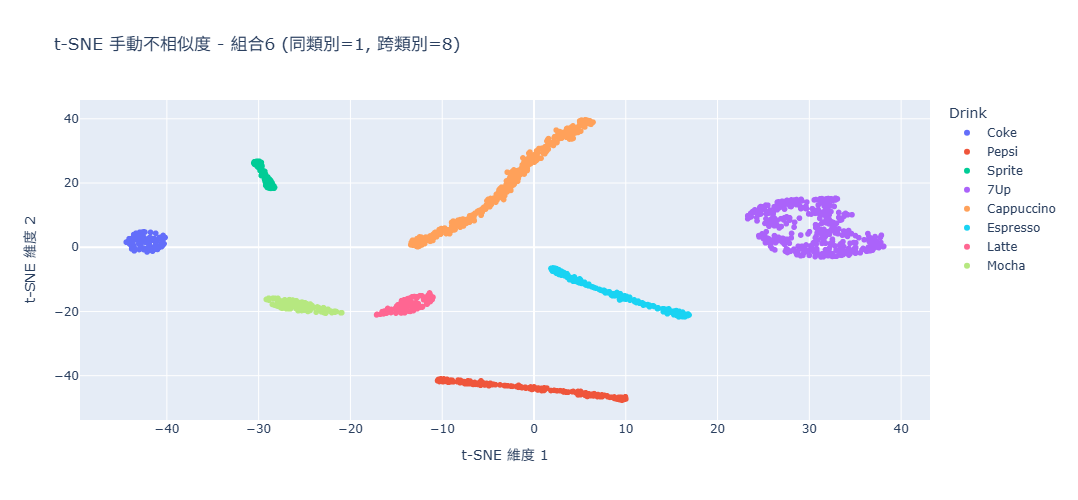

   📊 組合 7/9: 同類別=2, 跨類別=4
展開資料...
資料展開完成：從 8 行展開為 1600 行


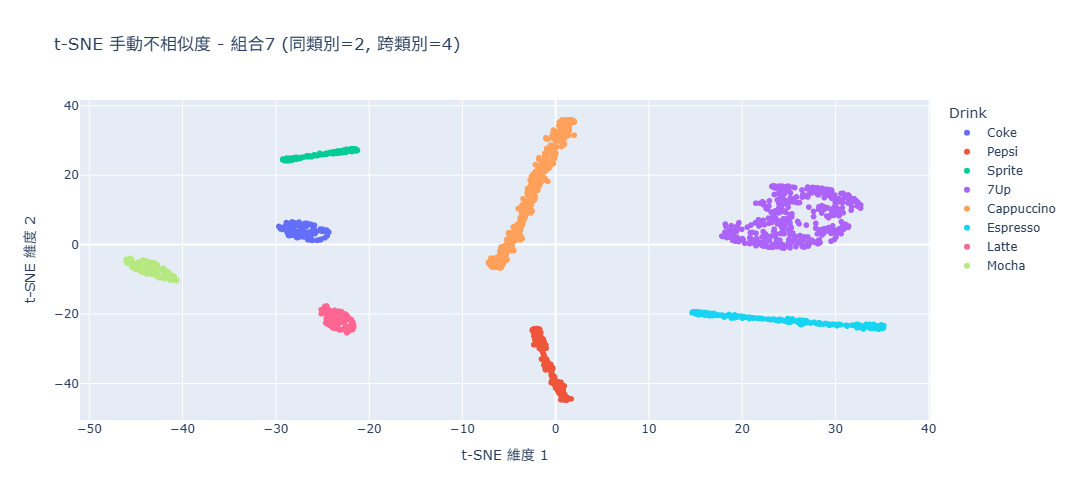

   📊 組合 8/9: 同類別=2, 跨類別=6
展開資料...
資料展開完成：從 8 行展開為 1600 行


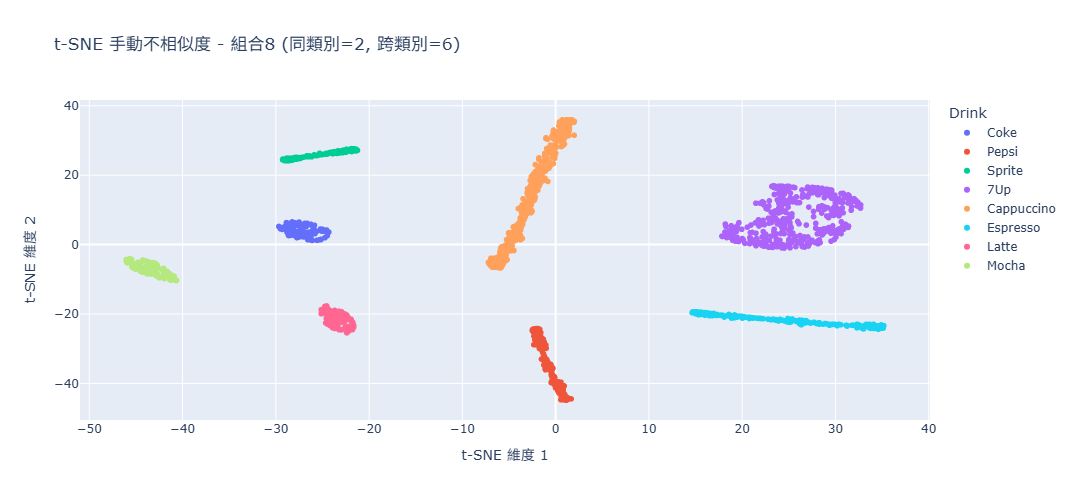

   📊 組合 9/9: 同類別=2, 跨類別=8
展開資料...
資料展開完成：從 8 行展開為 1600 行


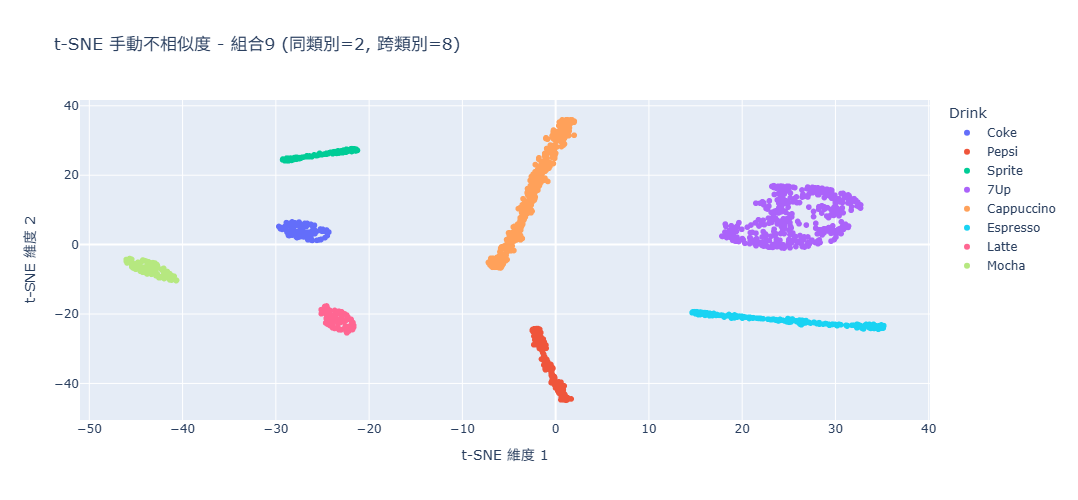

九種組合t-SNE全部顯示完成

🤖 4. t-SNE (Word2Vec不相似度)...
展開資料...
資料展開完成：從 8 行展開為 1600 行
   保存Word2Vec t-SNE圖片到: C:/Users/user/Desktop/ML_Work4/outputs\tsne_word2vec.png
   保存Word2Vec t-SNE資料到: C:/Users/user/Desktop/ML_Work4/outputs\tsne_word2vec.csv


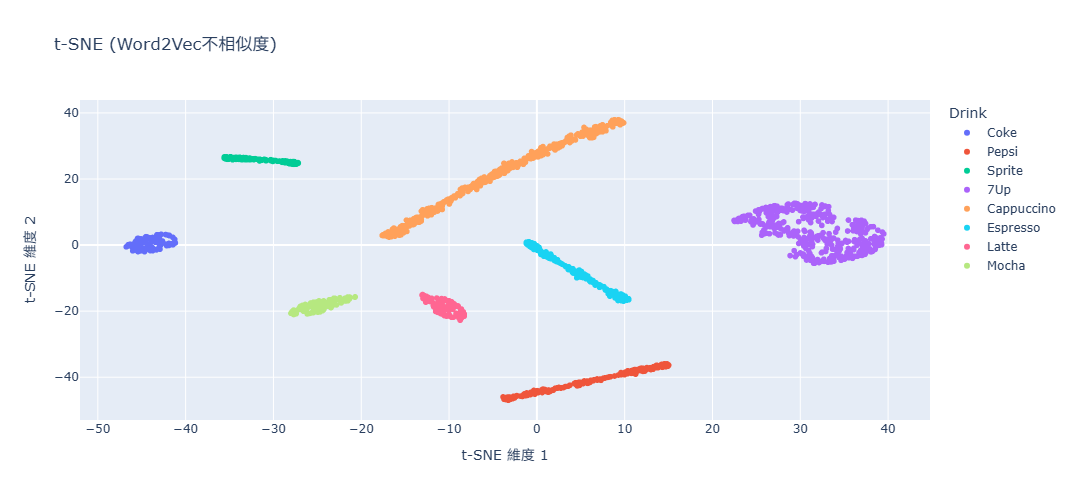

Word2Vec不相似度t-SNE顯示完成

已生成檔案:
 train_stations_map.html
 mds_train_stations.png
 tsne_one_hot.png
 tsne_word2vec.png
 tsne_manual_same0_cross4.png
 tsne_manual_same0_cross6.png
 tsne_manual_same0_cross8.png
 tsne_manual_same1_cross4.png
 tsne_manual_same1_cross6.png
 tsne_manual_same1_cross8.png
 tsne_manual_same2_cross4.png
 tsne_manual_same2_cross6.png
 tsne_manual_same2_cross8.png

所有互動式圖表生成完成
總共顯示了 12 張互動圖表：
 1張 火車站MDS圖
 1張 One-hot編碼t-SNE圖
 9張 手動不相似度組合t-SNE圖
 1張 Word2Vec不相似度t-SNE圖

互動功能：
  每張圖都支援拖拉圈選資料點
  縮放、平移、懸停查看詳情
  圈選後在控制台顯示資料統計
  所有圖表都已保存為PNG和CSV檔案

✨ 程式執行完成！


In [15]:
def main():
    """主程式"""
    print("開始執行機器學習作業四...")
    
    # 讀取飲料資料集
    print("讀取飲料資料集...")
    df = load_drink_dataset()
    if df is None:
        print("飲料資料集載入失敗")
        return
    print("飲料資料集載入完成")
    
    print("\n" + "="*60)
    print("開始生成所有互動式圖表")
    print("="*60)
    
    # 1. 火車站MDS圖
    print("\n1. 火車站MDS圖...")
    mds_coords, station_names = process_train_stations()
    fig_mds, mds_df = create_interactive_mds_plot(mds_coords, station_names)
    fig_mds.show()
    print("火車站MDS圖顯示完成")
    
    # 2. One-hot編碼t-SNE
    print("\n 2. t-SNE (One-hot編碼)...")
    tsne_onehot_data = tsne_one_hot(df)
    fig_onehot = create_interactive_tsne_plot(
        tsne_onehot_data, 
        "t-SNE (One-hot編碼)", 
        "onehot"
    )
    fig_onehot.show()
    print("One-hot編碼t-SNE顯示完成")
    
    # 3. 九種手動不相似度組合t-SNE
    print("\n⚙️  3. 九種手動不相似度組合t-SNE...")
    same_category_levels = [0, 1, 2]
    cross_category_levels = [4, 6, 8]
    
    combination_figures = []
    combination_data = []
    
    for row_idx, same_diss in enumerate(same_category_levels):
        for col_idx, cross_diss in enumerate(cross_category_levels):
            combination_idx = row_idx * 3 + col_idx + 1
            print(f"   📊 組合 {combination_idx}/9: 同類別={same_diss}, 跨類別={cross_diss}")
            
            # 計算t-SNE
            tsne_manual_data = tsne_manual_combination(df, same_diss, cross_diss)
            
            # 建立圖表
            title = f"t-SNE 手動不相似度 - 組合{combination_idx} (同類別={same_diss}, 跨類別={cross_diss})"
            fig_manual = create_interactive_tsne_plot(
                tsne_manual_data,
                title,
                f"manual_{same_diss}_{cross_diss}"
            )
            
            # 保存圖片
            filename = f'tsne_manual_same{same_diss}_cross{cross_diss}'
            fig_manual.write_image(file=os.path.join(OUTPUT_DIR, f'{filename}.png'), format='png')
            tsne_manual_data.to_csv(os.path.join(OUTPUT_DIR, f'{filename}.csv'), index=False)
            
            # 顯示圖表
            fig_manual.show()
            
            combination_figures.append(fig_manual)
            combination_data.append(tsne_manual_data)
    
    print("九種組合t-SNE全部顯示完成")
    
    # 4. Word2Vec不相似度t-SNE
    print("\n🤖 4. t-SNE (Word2Vec不相似度)...")
    tsne_w2v_data = tsne_word2vec(df)
    fig_w2v = create_interactive_tsne_plot(
        tsne_w2v_data, 
        "t-SNE (Word2Vec不相似度)", 
        "word2vec"
    )
    fig_w2v.show()
    print("Word2Vec不相似度t-SNE顯示完成")
    

    
    # 顯示檔案輸出資訊
    print("\n已生成檔案:")
    print(" train_stations_map.html")
    print(" mds_train_stations.png")
    print(" tsne_one_hot.png")
    print(" tsne_word2vec.png")

    
    for same_diss in same_category_levels:
        for cross_diss in cross_category_levels:
            print(f" tsne_manual_same{same_diss}_cross{cross_diss}.png")
    
    print("\n" + "="*60)
    print("所有互動式圖表生成完成")
    print("="*60)
    print("總共顯示了 12 張互動圖表：")
    print(" 1張 火車站MDS圖")
    print(" 1張 One-hot編碼t-SNE圖")
    print(" 9張 手動不相似度組合t-SNE圖")
    print(" 1張 Word2Vec不相似度t-SNE圖")
    print("\n互動功能：")
    print("  每張圖都支援拖拉圈選資料點")
    print("  縮放、平移、懸停查看詳情")
    print("  圈選後在控制台顯示資料統計")
    print("  所有圖表都已保存為PNG和CSV檔案")
    print("\n✨ 程式執行完成！")

if __name__ == '__main__':
    main()